In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_importance

### 추후에 s3와 연동

In [2]:
df_01 = pd.read_csv('../dataset/LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv')
df_02 = pd.read_csv('../dataset/LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv')
df_03 = pd.read_csv('../dataset/LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv')
df_04 = pd.read_csv('../dataset/LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv')
df_05 = pd.read_csv('../dataset/LPOINT_BIG_COMP/LPOINT_BIG_COMP_05_BR.csv')
df_06 = pd.read_csv('../dataset/LPOINT_BIG_COMP/LPOINT_BIG_COMP_06_LPAY.csv')

In [3]:
df_04['clac_hlv_nm'].nunique()

60

In [4]:
df_01.drop('zon_hlv', axis=1, inplace=True)
df_02.drop(['rct_no', 'chnl_dv', 'br_c'], axis=1, inplace=True)
df_04.drop(['pd_nm', 'clac_mcls_nm'], axis=1, inplace=True)

In [5]:
df_merge_01_02 = pd.merge(df_02, df_01, on='cust')
df_merge_01_02_04 = pd.merge(df_merge_01_02, df_04, on='pd_c')
df_merge_01_02_04.drop('pd_c', axis=1, inplace=True)

In [6]:
df = df_merge_01_02_04.sort_values('de_dt').reset_index(drop=True)

In [7]:
for i in df.columns:
    globals()[f'encoder_{i}'] = LabelEncoder()
    df[i] = globals()[f'encoder_{i}'].fit_transform(df[i])

In [8]:
globals()['encoder_cust'].inverse_transform(df['cust'])

array(['M430112881', 'M795981455', 'M254394691', ..., 'M381508423',
       'M055905901', 'M528799855'], dtype=object)

                 cust     cop_c     de_dt     de_hr    buy_am    buy_ct  \
cust         1.000000 -0.002124 -0.000774 -0.003549 -0.001258 -0.000662   
cop_c       -0.002124  1.000000 -0.024109 -0.031356 -0.290840  0.028712   
de_dt       -0.000774 -0.024109  1.000000  0.022351  0.018674  0.000407   
de_hr       -0.003549 -0.031356  0.022351  1.000000 -0.058548 -0.004934   
buy_am      -0.001258 -0.290840  0.018674 -0.058548  1.000000  0.055173   
buy_ct      -0.000662  0.028712  0.000407 -0.004934  0.055173  1.000000   
ma_fem_dv    0.002192 -0.086899 -0.018556 -0.027033  0.028259 -0.002199   
ages         0.006550 -0.055706 -0.014344 -0.026687  0.015303  0.016666   
clac_hlv_nm  0.000348 -0.064376  0.002246 -0.020741  0.065002  0.015743   

             ma_fem_dv      ages  clac_hlv_nm  
cust          0.002192  0.006550     0.000348  
cop_c        -0.086899 -0.055706    -0.064376  
de_dt        -0.018556 -0.014344     0.002246  
de_hr        -0.027033 -0.026687    -0.020741  
buy_am   

<AxesSubplot:>

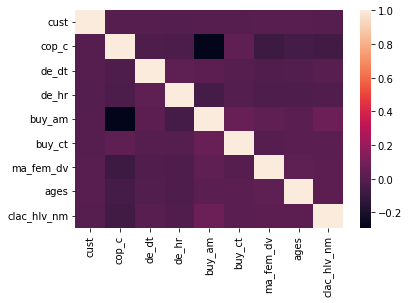

In [9]:
print(df.corr())
sns.heatmap(df.corr())

In [10]:
x = df.drop(columns='clac_hlv_nm', axis=1)
y = df['clac_hlv_nm']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)

(3286307, 8) (1095436, 8)
(2957676, 8) (328631, 8)


In [12]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [37]:
params = { 'max_depth':5,
           'num_class':60,
           'eta':0.05,
           'objective':'multi:softmax',
           'eval_metric':'mlogloss',
           'tree_method':'gpu_hist',
           'gpu_id':0
         }
num_rounds = 500

# 'tree_method':'gpu_hist',
# 'gpu_id':0

In [ ]:
eval_list = [(dtr,'train'),(dval,'eval')]

xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds, \
                      early_stopping_rounds=50, evals=eval_list)

[0]	train-mlogloss:3.91803	eval-mlogloss:3.91858
[1]	train-mlogloss:3.79810	eval-mlogloss:3.79905
[2]	train-mlogloss:3.70192	eval-mlogloss:3.70312
[3]	train-mlogloss:3.62007	eval-mlogloss:3.62148
[4]	train-mlogloss:3.54904	eval-mlogloss:3.55069
[5]	train-mlogloss:3.48589	eval-mlogloss:3.48767
[6]	train-mlogloss:3.42919	eval-mlogloss:3.43115
[7]	train-mlogloss:3.37787	eval-mlogloss:3.37993
[8]	train-mlogloss:3.33097	eval-mlogloss:3.33322
[9]	train-mlogloss:3.28828	eval-mlogloss:3.29068
[10]	train-mlogloss:3.24884	eval-mlogloss:3.25141
[11]	train-mlogloss:3.21197	eval-mlogloss:3.21469
[12]	train-mlogloss:3.17855	eval-mlogloss:3.18145
[13]	train-mlogloss:3.14681	eval-mlogloss:3.14983
[14]	train-mlogloss:3.11722	eval-mlogloss:3.12037
[15]	train-mlogloss:3.08923	eval-mlogloss:3.09252
[16]	train-mlogloss:3.06297	eval-mlogloss:3.06642
[17]	train-mlogloss:3.03836	eval-mlogloss:3.04191
[18]	train-mlogloss:3.01529	eval-mlogloss:3.01893
[19]	train-mlogloss:2.99292	eval-mlogloss:2.99669
[20]	train

[163]	train-mlogloss:2.38648	eval-mlogloss:2.39659
[164]	train-mlogloss:2.38573	eval-mlogloss:2.39588
[165]	train-mlogloss:2.38496	eval-mlogloss:2.39514
[166]	train-mlogloss:2.38430	eval-mlogloss:2.39451
[167]	train-mlogloss:2.38342	eval-mlogloss:2.39366
[168]	train-mlogloss:2.38277	eval-mlogloss:2.39303
[169]	train-mlogloss:2.38205	eval-mlogloss:2.39236
[170]	train-mlogloss:2.38122	eval-mlogloss:2.39156
[171]	train-mlogloss:2.38036	eval-mlogloss:2.39072
[172]	train-mlogloss:2.37944	eval-mlogloss:2.38984
[173]	train-mlogloss:2.37862	eval-mlogloss:2.38906
[174]	train-mlogloss:2.37788	eval-mlogloss:2.38834
[175]	train-mlogloss:2.37722	eval-mlogloss:2.38772
[176]	train-mlogloss:2.37635	eval-mlogloss:2.38688
[177]	train-mlogloss:2.37570	eval-mlogloss:2.38626
[178]	train-mlogloss:2.37488	eval-mlogloss:2.38548
[179]	train-mlogloss:2.37428	eval-mlogloss:2.38490
[180]	train-mlogloss:2.37354	eval-mlogloss:2.38418
[181]	train-mlogloss:2.37290	eval-mlogloss:2.38358
[182]	train-mlogloss:2.37214	ev

[324]	train-mlogloss:2.30064	eval-mlogloss:2.31672
[325]	train-mlogloss:2.30025	eval-mlogloss:2.31636
[326]	train-mlogloss:2.29989	eval-mlogloss:2.31604
[327]	train-mlogloss:2.29954	eval-mlogloss:2.31573
[328]	train-mlogloss:2.29913	eval-mlogloss:2.31536
[329]	train-mlogloss:2.29878	eval-mlogloss:2.31505
[330]	train-mlogloss:2.29841	eval-mlogloss:2.31471
[331]	train-mlogloss:2.29803	eval-mlogloss:2.31436
[332]	train-mlogloss:2.29770	eval-mlogloss:2.31406
[333]	train-mlogloss:2.29736	eval-mlogloss:2.31376
[334]	train-mlogloss:2.29703	eval-mlogloss:2.31347
[335]	train-mlogloss:2.29668	eval-mlogloss:2.31315
[336]	train-mlogloss:2.29633	eval-mlogloss:2.31283
[337]	train-mlogloss:2.29598	eval-mlogloss:2.31253
[338]	train-mlogloss:2.29559	eval-mlogloss:2.31218
[339]	train-mlogloss:2.29522	eval-mlogloss:2.31184
[340]	train-mlogloss:2.29488	eval-mlogloss:2.31154
[341]	train-mlogloss:2.29446	eval-mlogloss:2.31116
[342]	train-mlogloss:2.29412	eval-mlogloss:2.31085
[343]	train-mlogloss:2.29377	ev

[485]	train-mlogloss:2.24949	eval-mlogloss:2.27118
[486]	train-mlogloss:2.24922	eval-mlogloss:2.27096
[487]	train-mlogloss:2.24897	eval-mlogloss:2.27074
[488]	train-mlogloss:2.24870	eval-mlogloss:2.27050
[489]	train-mlogloss:2.24840	eval-mlogloss:2.27022
[490]	train-mlogloss:2.24812	eval-mlogloss:2.26997
[491]	train-mlogloss:2.24785	eval-mlogloss:2.26974
[492]	train-mlogloss:2.24761	eval-mlogloss:2.26953
[493]	train-mlogloss:2.24730	eval-mlogloss:2.26926
[494]	train-mlogloss:2.24709	eval-mlogloss:2.26908
[495]	train-mlogloss:2.24681	eval-mlogloss:2.26882
[496]	train-mlogloss:2.24656	eval-mlogloss:2.26861
[497]	train-mlogloss:2.24632	eval-mlogloss:2.26840
[498]	train-mlogloss:2.24604	eval-mlogloss:2.26816
[499]	train-mlogloss:2.24577	eval-mlogloss:2.26793
[500]	train-mlogloss:2.24550	eval-mlogloss:2.26770
[501]	train-mlogloss:2.24526	eval-mlogloss:2.26749
[502]	train-mlogloss:2.24505	eval-mlogloss:2.26730
[503]	train-mlogloss:2.24479	eval-mlogloss:2.26707
[504]	train-mlogloss:2.24453	ev

[646]	train-mlogloss:2.21207	eval-mlogloss:2.23892
[647]	train-mlogloss:2.21185	eval-mlogloss:2.23873
[648]	train-mlogloss:2.21167	eval-mlogloss:2.23858
[649]	train-mlogloss:2.21150	eval-mlogloss:2.23845
[650]	train-mlogloss:2.21128	eval-mlogloss:2.23826
[651]	train-mlogloss:2.21106	eval-mlogloss:2.23807
[652]	train-mlogloss:2.21084	eval-mlogloss:2.23788
[653]	train-mlogloss:2.21067	eval-mlogloss:2.23774
[654]	train-mlogloss:2.21043	eval-mlogloss:2.23753
[655]	train-mlogloss:2.21017	eval-mlogloss:2.23731
[656]	train-mlogloss:2.20999	eval-mlogloss:2.23717
[657]	train-mlogloss:2.20978	eval-mlogloss:2.23700
[658]	train-mlogloss:2.20959	eval-mlogloss:2.23684
[659]	train-mlogloss:2.20937	eval-mlogloss:2.23667
[660]	train-mlogloss:2.20915	eval-mlogloss:2.23648
[661]	train-mlogloss:2.20893	eval-mlogloss:2.23629
[662]	train-mlogloss:2.20873	eval-mlogloss:2.23613
[663]	train-mlogloss:2.20851	eval-mlogloss:2.23595
[664]	train-mlogloss:2.20830	eval-mlogloss:2.23578
[665]	train-mlogloss:2.20808	ev

[807]	train-mlogloss:2.18272	eval-mlogloss:2.21485
[808]	train-mlogloss:2.18252	eval-mlogloss:2.21467
[809]	train-mlogloss:2.18235	eval-mlogloss:2.21452
[810]	train-mlogloss:2.18216	eval-mlogloss:2.21435
[811]	train-mlogloss:2.18200	eval-mlogloss:2.21423
[812]	train-mlogloss:2.18179	eval-mlogloss:2.21405
[813]	train-mlogloss:2.18161	eval-mlogloss:2.21389
[814]	train-mlogloss:2.18148	eval-mlogloss:2.21379
[815]	train-mlogloss:2.18131	eval-mlogloss:2.21364
[816]	train-mlogloss:2.18117	eval-mlogloss:2.21353
[817]	train-mlogloss:2.18103	eval-mlogloss:2.21342
[818]	train-mlogloss:2.18089	eval-mlogloss:2.21332
[819]	train-mlogloss:2.18073	eval-mlogloss:2.21318
[820]	train-mlogloss:2.18055	eval-mlogloss:2.21304
[821]	train-mlogloss:2.18041	eval-mlogloss:2.21293
[822]	train-mlogloss:2.18023	eval-mlogloss:2.21278
[823]	train-mlogloss:2.18008	eval-mlogloss:2.21265
[824]	train-mlogloss:2.17990	eval-mlogloss:2.21250
[825]	train-mlogloss:2.17975	eval-mlogloss:2.21238
[826]	train-mlogloss:2.17959	ev

In [34]:
pred_probs = xgb_model.predict(dtest)
print(pred_probs)

[19. 17. 44. ... 48. 48. 13.]


In [35]:
from sklearn.metrics import accuracy_score

In [36]:
accuracy = accuracy_score(y_test, pred_probs)
accuracy

0.3418218864452145